In [124]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from binance.client import Client
import datetime as dt
from pytz import timezone
from scipy.stats import zscore

In [ ]:
# 1. Data Retrieval

# Objective: Retrieve historical data using the API of a crypto exchange, such as Kraken or Binance. Requirements:
# • Select either BTCUSD or ETHUSD on Kraken, or BTCUSDT or ETHUSD on Binance as the trading pair. ☑️
# • Retrieve at least 30 days of 1-minute interval data for OHLC (Open, High, Low, Close) prices and trading volume. ☑️
# • Provide code that demonstrates the data retrieval process via the API. ☑️

#---------------------------------------------------------------------------------------------------------------------------------

api_key = 'hbJL4wO7LeYX6FkKuVW08PpoBgiOUOwdUYAhYLSG40xzpaywcEPgRjPgGBXGyS3B'
api_secret = 'qHm85rDfxljX5FhvjoAVEPbQ119Teu78SAw9KERQ3YtLD8mMHH2NRVUNef9Tb2zX'

client = Client(api_key, api_secret)


def get_historical_klines(symbol, interval, start_str, end_str=None):
    
    # Fetch historical klines from Binance.

    # param symbol: str e.g., 'BTCUSDT'
    # param interval: str e.g., Client.KLINE_INTERVAL_1HOUR
    # param start_str: str e.g., '7 Nov, 2024'
    # param end_str: str e.g., '6 Dec, 2024' (optional)
    # possible columns:  'open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades','taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    # return: pd.DataFrame
   
    klines = client.get_historical_klines(symbol, interval, start_str, end_str)
    df = pd.DataFrame(klines, columns=[
        'open_time', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df.set_index('open_time', inplace=True)
    # Keep only the Open, High, Low, Close columns and convert them to float
    df = df[['open', 'high', 'low', 'close']].astype(float)
    return df


#---------------------------------------------------------------------------------------------------------------------------------

#Run the program:

symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_1MINUTE  # 1-minute intervals
start_date = '7 Nov, 2024'
end_date = '6 Dec, 2024'

df = get_historical_klines(symbol, interval, start_date, end_date)

#save the dataframe in a csv format:

file_name = "Binance_BTCUSDT_30Days_1Min.csv" 
df.to_csv(file_name)


In [ ]:
# 2. Data Cleaning 1/4 - General Inspection of the datasets

# Objective: Preprocess the raw data to make it suitable for analysis. Requirements:
# • Handle any missing timestamps or NaN values. ☑️
# • Remove duplicate rows, if any. ☑️
# • Convert timestamps to the CET timezone. ☑️


# Comment from Tim: 
# As my csv file from Task 1 already contains an ISO time, 
# I will use Matteo's csv files to demonstrate how I translate the time format from UNIX timestamp to ISO time.

#---------------------------------------------------------------------------------------------------------------------------------

def process_and_validate_file(filename):


    # Load the dataset
    data = pd.read_csv(filename)
    
    # Convert the 'time' column to a datetime object in UTC and then to CET
    data['time'] = pd.to_datetime(data['time'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Europe/Berlin')
    
    # Check for missing timestamps
    time_diff = data['time'].diff().value_counts()
    print(f"Timestamp Intervals in {filename}:")
    print(time_diff)
    
    if time_diff.shape[0] == 1 and time_diff.index[0] == pd.Timedelta(minutes=1):
        print("\nTimestamps are consistent (1-minute intervals). ✔️")
    else:
        print("\nTimestamps are not consistent. Please investigate further. ❌")
    
    # Check for missing values (NaN) in the dataset
    missing_values = data.isna().sum()
    print(f"\nMissing Values in {filename}:")
    print(missing_values)
    
    if missing_values.sum() == 0:
        print("No missing values in the dataset. ✔️")
    else:
        print("There are missing values in the dataset. Please address them. ❌")
    
    # Check for duplicate rows
    duplicate_count = data.duplicated().sum()
    print(f"\nNumber of duplicate rows in {filename}: {duplicate_count}")
    
    if duplicate_count > 0:
        print("Duplicate rows found. Consider removing them for a clean dataset. ❌")
    else:
        print("No duplicate rows found. ✔️")
    
    # Optional: Drop duplicates (uncomment if needed)
    # data = data.drop_duplicates()
    
    return data

#---------------------------------------------------------------------------------------------------------------------------------

# Enter file name and run the program:
filename = 'KRAKEN_ETHUSD_interpolated.csv'  
processed_data = process_and_validate_file(filename)

# Save the processed data to a new file
# output_filename = "KRAKEN_ETHUSD_CLEANED.csv"
# processed_data.to_csv(output_filename, index=False)
# print(f"Cleaned dataset saved as {output_filename}.")

# Comment from Tim: 
# If there should be missing timestamps or NaN values, one would need to discuss whether to entirely drop these rows (just like the duplicates),
# or whether one fills it with a value, such as: Forward-fill, Backward-fill, linear interpolation, etc. It depends on the goal of the data analysis.
# Examples for handling irregularities:
    # Forward-fill: data.fillna(method='ffill', inplace=True)
    # Backward-fill: data.fillna(method='bfill', inplace=True)
    # Fill with specific value (e.g., 0): data.fillna(0, inplace=True)
    # Drop Rows: data.dropna(inplace=True)
    # Linear Interpolation: data.interpolate(method='linear', inplace=True)


Timestamp Intervals in KRAKEN_ETHUSD_interpolated.csv:
time
0 days 00:01:00    3384
Name: count, dtype: int64

Timestamps are consistent (1-minute intervals). ✔️

Missing Values in KRAKEN_ETHUSD_interpolated.csv:
time      0
open      0
high      0
low       0
close     0
Volume    0
dtype: int64
No missing values in the dataset. ✔️

Number of duplicate rows in KRAKEN_ETHUSD_interpolated.csv: 0
No duplicate rows found. ✔️
Cleaned dataset saved as KRAKEN_ETHUSD_CLEANED.csv.


In [ ]:
# 2. Data Cleaning 2/4 - Clean the Kraken dataset. Interpolate missing timestamps.

# Load your dataset
file_path = 'KRAKEN_ETHUSD.csv'  # Adjust the path as needed
eth_data = pd.read_csv(file_path)

# Ensure the 'time' column is numeric
eth_data['time'] = pd.to_numeric(eth_data['time'], errors='coerce')

# Set the time column as the index and create a complete time range
eth_data.set_index('time', inplace=True)
complete_time_index = pd.RangeIndex(start=eth_data.index.min(), stop=eth_data.index.max() + 60, step=60)

# Reindex the dataframe to include all timestamps
eth_data = eth_data.reindex(complete_time_index)

# Reset index back to the 'time' column
eth_data.reset_index(inplace=True)
eth_data.rename(columns={'index': 'time'}, inplace=True)

# Perform linear interpolation for missing values
eth_data.interpolate(method='linear', inplace=True)

# Save the corrected dataset (optional)
eth_data.to_csv('KRAKEN_ETHUSD_interpolated.csv', index=False)

print("Missing rows have been interpolated. The dataset now has 1-minute intervals.")

Missing rows have been interpolated. The dataset now has 1-minute intervals.


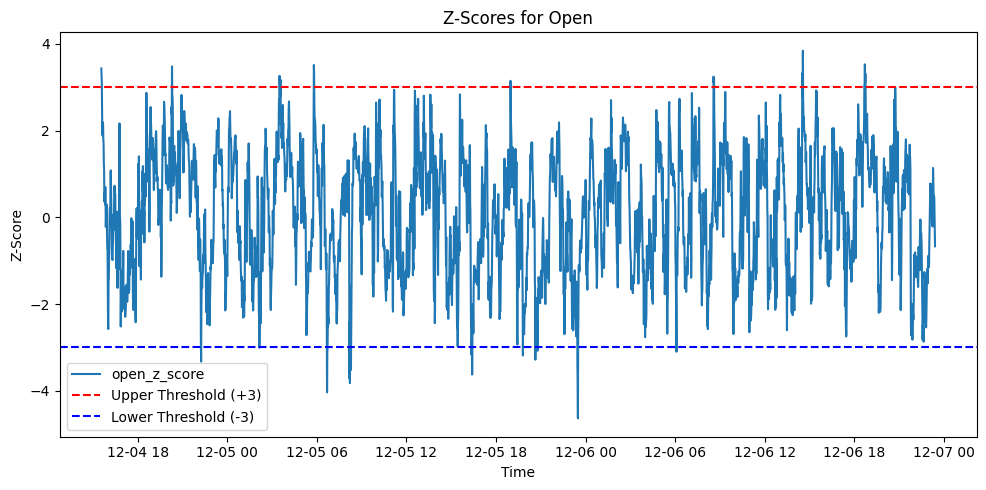

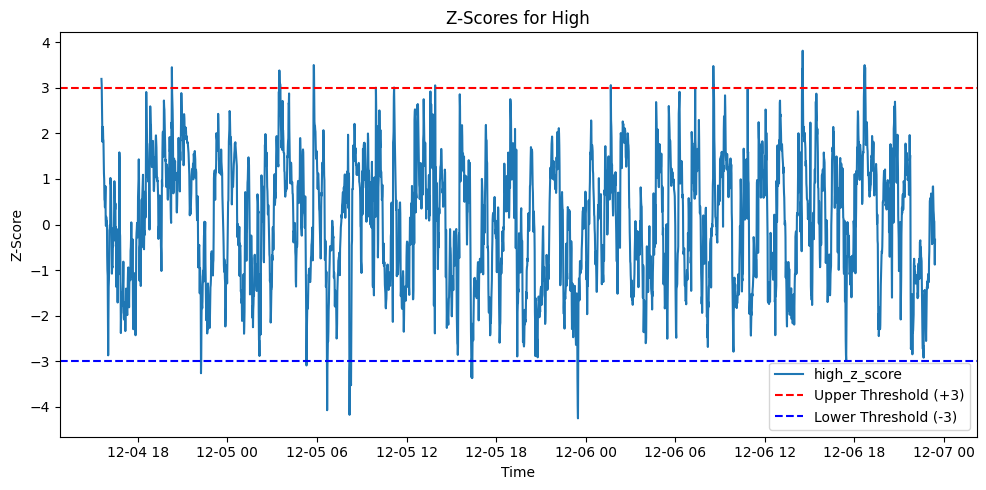

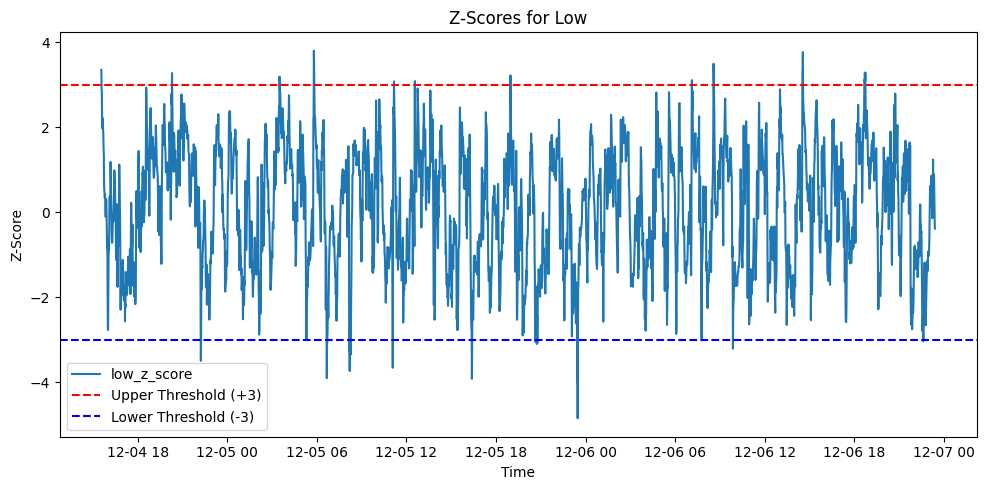

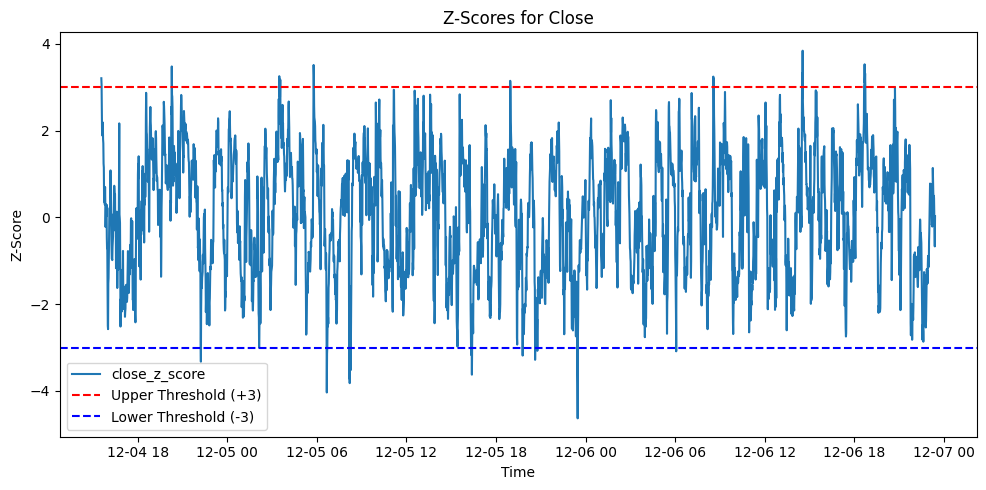

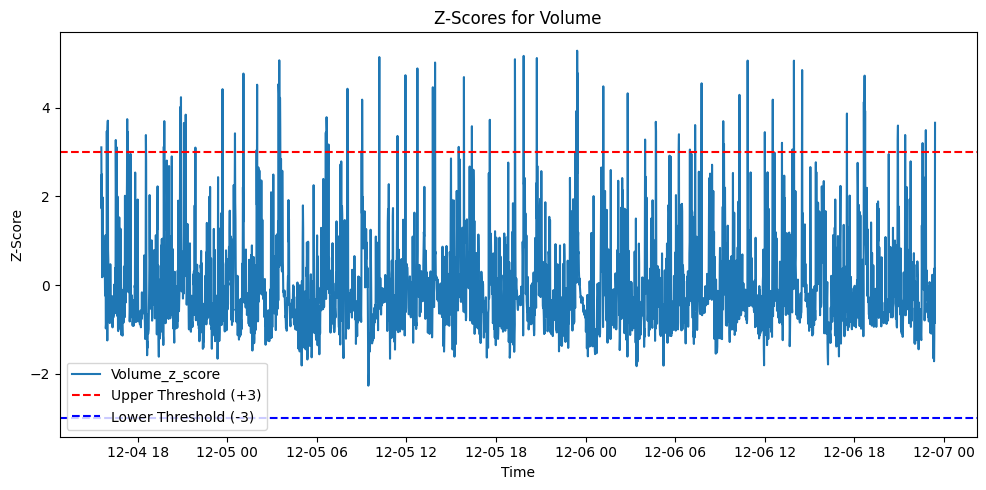

In [ ]:
# 2. Data Cleaning 3/4
# • Address outliers in price or volume (explain your approach). ☑️

# Comment from Tim: 
# I will use a rolling Z-Score to identify outliers.
# The rolling window is 30min.
# Datapoints with Z-Score beyond ±3 I will consider as an outlier.
# As an example, I will demonstrate my approach with the "BINANCE_BTCUSDT_CLEANED.csv" dataset.
# I will visualize my idea with plots for each feature.

#---------------------------------------------------------------------------------------------------------------------------------


file_name = 'BINANCE_BTCUSDT_CLEANED.csv'  
data = pd.read_csv(file_name)

# Ensure 'time' is treated as a datetime object
data['time'] = pd.to_datetime(data['time'])

# Set 'time' as the index to handle rolling operations easily
data.set_index('time', inplace=True)

# Function to calculate rolling Z-Score
def rolling_z_score(series, window_size):
    rolling_mean = series.rolling(window=window_size).mean()
    rolling_std = series.rolling(window=window_size).std()
    z_score = (series - rolling_mean) / rolling_std
    return z_score

# Define the rolling window in minutes (30 minutes for a 1-minute interval dataset)
window_size = 30

# Apply the rolling Z-Score and detect outliers for each relevant column
columns_to_check = ['open', 'high', 'low', 'close', 'Volume']
for column in columns_to_check:
    z_score_column = f"{column}_z_score"
    outlier_column = f"{column}_outlier"
    
    # Calculate rolling Z-Score
    data[z_score_column] = rolling_z_score(data[column], window_size)
    
    # Identify outliers based on Z-Score threshold
    data[outlier_column] = (data[z_score_column].abs() > 3)

# Save the dataset with the new outlier columns to the current directory
output_file_name = file_name.replace("CLEANED", "OUTLIERS")
data.to_csv(output_file_name)

columns_to_plot = ['open_z_score', 'high_z_score', 'low_z_score', 'close_z_score', 'Volume_z_score']

for column in columns_to_plot:
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data[column], label=column)
    plt.axhline(3, color='red', linestyle='--', label='Upper Threshold (+3)')
    plt.axhline(-3, color='blue', linestyle='--', label='Lower Threshold (-3)')
    plt.title(f"Z-Scores for {column.replace('_z_score', '').capitalize()}")
    plt.xlabel('Time')
    plt.ylabel('Z-Score')
    plt.legend()
    plt.tight_layout()
    plt.show()





In [131]:
# 2. Data Cleaning 4/4
# • Aggregate the data into hourly intervals while maintaining the OHLC structure. ☑️

file_path = "Cleaned Datasets/KRAKEN_BTCUSD_CLEANED.csv"
data = pd.read_csv(file_path)

# Ensure the timestamp column is in datetime format
data['time'] = pd.to_datetime(data['time'])

# Set the timestamp column as the DataFrame index
data.set_index('time', inplace=True)

# Resample to hourly frequency and calculate the mean for all numeric columns
resampled_data = data.resample('H').mean()

# Reset the index if required
resampled_data.reset_index(inplace=True)

# Save or view the resampled dataset
output_file = "KRAKEN_BTCUSD_CLEANED_1H.csv"
resampled_data.to_csv(output_file, index=False)
print(f"Resampled data saved to {output_file}")

Resampled data saved to KRAKEN_BTCUSD_CLEANED_1H.csv


/tmp/ipykernel_9375/1706049815.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_data = data.resample('H').mean()
